# The Late Show with Stephen Colbert Analysis

## Standard Imports

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import pandas as pd
import seaborn as sns
from textblob import TextBlob
import statsmodels.formula.api as smf

plt.rcParams['figure.figsize'] = (20,6)

import bokeh.charts
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import HoverTool, BoxSelectTool, ColumnDataSource
bokeh.charts.defaults.width = 950
bokeh.charts.defaults.height = 400
output_notebook(hide_banner=True)

from IPython.display import display, HTML
def printb(*args):
    s = " ".join([str(x) for x in args])
    display(HTML('<strong>%s</strong>' % s))

from analysis import create_df

## Load Data

In [2]:
episodes = create_df()
episodes.head()

number  rating  rating_count    airdate  \
0       1     7.5          97.0 2015-09-08   
1       2     7.5          58.0 2015-09-09   
2       3     8.6          66.0 2015-09-10   
3       4     7.4          42.0 2015-09-11   
4       5     7.9          36.0 2015-09-14   

                                               title  \
0  George Clooney/Governor Jeb Bush/Mavis Staples...   
1        Scarlett Johansson/Elon Musk/Kendrick Lamar   
2  Vice President Joe Biden/Travis Kalanick/Toby ...   
3           Amy Schumer/Stephen King/Troubled Waters   
4  Emily Blunt/Justice Stephen Breyer/The Dead We...   

                                         description  \
0  Stephen Colbert succeeds David Letterman as "L...   
1  Scarlett Johansson (Avengers: Age of Ultron (2...   
2  Vice President Joe Biden; Uber CEO Travis Kala...   
3  Amy Schumer (Trainwreck (2015)); author Stephe...   
4  Actress Emily Blunt (Sicario (2015)); Supreme ...   

                                                text  
0  OH, SAY CAN YOU SEE BY THE DAWN'S EARLY LIGHT ...  
1  ♪ ♪ ♪  Captioning sponsored by CBS\nStephen: W...  
2  (CHEERS AND APPLAUSE)\nStephen: HEY! (CHEERS A...  
3  COME ON! COME ON! ♪ ♪ ♪ ( CHEERS AND APPLAUSE ...  
4  (  BAND PLAYING  "LATE SHOW" THEME  ) (  CHEER...

## Distribution of Rating and Rating Count

Number of episodes with null rating (< 5 ratings)

In [3]:
episodes.rating.isnull().sum()

15

In [4]:
episodes[['rating', 'rating_count']].describe().T

count       mean        std  min  25%  50%   75%   max
rating        124.0   7.565323   0.565260  5.9  7.2  7.7   8.0   9.0
rating_count  124.0  13.419355  12.373652  5.0  7.0  9.0  14.0  97.0

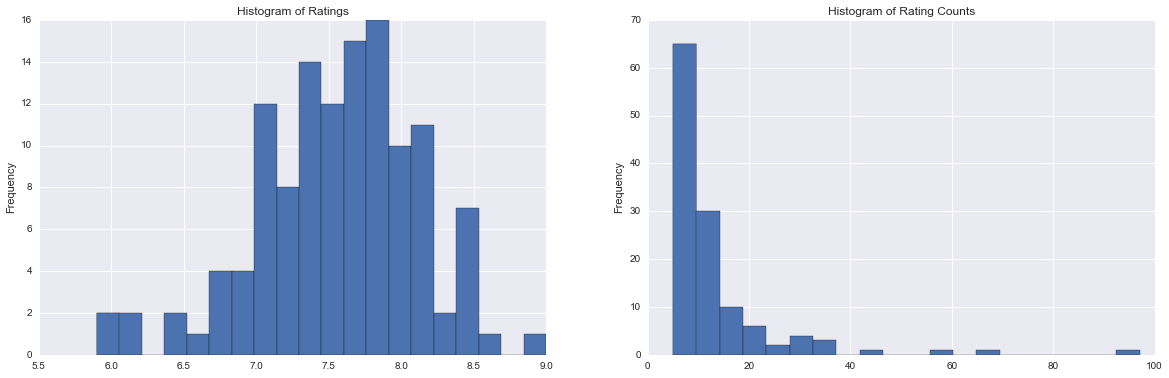

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

episodes.rating.plot(kind='hist', bins=20, ax=ax1, title="Histogram of Ratings")
episodes.rating_count.plot(kind='hist', bins=20, ax=ax2, title="Histogram of Rating Counts")

## Ratings over Time

In [6]:
p = figure(
    plot_width=bokeh.charts.defaults.width, 
    plot_height=bokeh.charts.defaults.height, 
    x_axis_type="datetime",
    title="Ratings per Episode on The Late Show with Stephen Colbert")

hover = HoverTool(tooltips=[
            ("Episode", "@number"),
            ("Title", "@title"),
            ("Airdate", "@airdatestr"), 
            ("Rating", "$y{1.11}")])

source = ColumnDataSource(episodes)
source.add(episodes.airdate.map(lambda x: x.strftime('%x')), 'airdatestr')
p.circle(x='airdate', y='rating', line_width=2, source=source, size=5)
p.add_tools(hover)
p.logo = None
show(p)

## Sentiment Analysis

In [7]:
rows = []
for index, row in episodes.iterrows():
    if pd.isnull(row.text): continue
    blob = TextBlob(row.text)
    sentiment = blob.sentiment
    row = {"number": row.number, "polarity": sentiment.polarity, "subjectivity": sentiment.subjectivity}
    rows.append(row)

sentiment = pd.DataFrame(rows).set_index('number')
episodes = pd.concat([episodes.set_index('number'), sentiment], axis=1).reset_index()
episodes[['number', 'airdate', 'polarity', 'subjectivity', 'rating', 'rating_count']].head()

number    airdate  polarity  subjectivity  rating  rating_count
0       1 2015-09-08  0.177883      0.527630     7.5          97.0
1       2 2015-09-09  0.177891      0.529692     7.5          58.0
2       3 2015-09-10  0.210318      0.500193     8.6          66.0
3       4 2015-09-11  0.148042      0.523307     7.4          42.0
4       5 2015-09-14  0.171476      0.469937     7.9          36.0

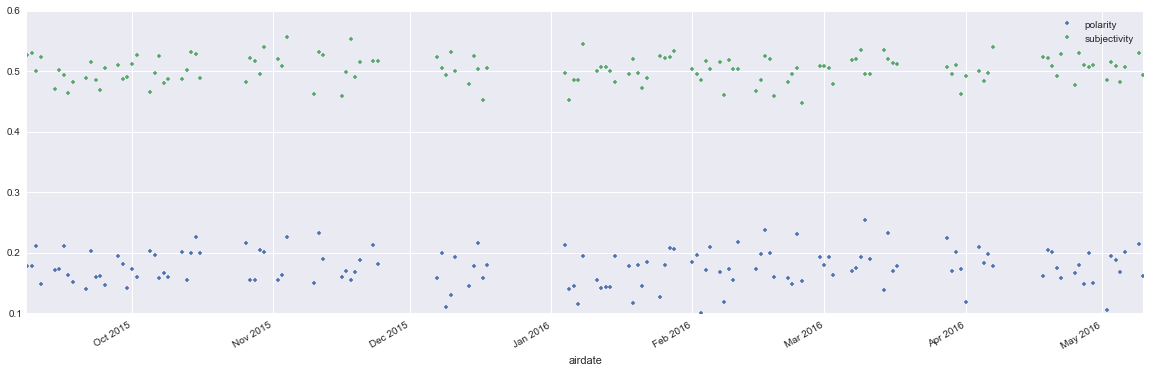

In [8]:
episodes.set_index('airdate').polarity.plot(style='.')
episodes.set_index('airdate').subjectivity.plot(style='.')
plt.legend()

In [9]:
mod = smf.ols(formula='rating ~ subjectivity + polarity', data=episodes)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 rating   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.2252
Date:                Thu, 12 May 2016   Prob (F-statistic):              0.799
Time:                        03:56:09   Log-Likelihood:                -101.49
No. Observations:                 119   AIC:                             209.0
Df Residuals:                     116   BIC:                             217.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept        6.8203      1.188      5.743      0.000         4.468     9.172
subjectivity     1.3520      2.419      0.559      0.577        -3.439     6.143
polarity         0.4420      1.862      0.237      0.813        -3.247     4.131
==============================================================================
Omnibus:                        5.996   Durbin-Watson:                   1.490
Prob(Omnibus):                  0.050   Jarque-Bera (JB):                5.466
Skew:                          -0.492   Prob(JB):                       0.0650
Kurtosis:                       3.366   Cond. No.                         58.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Subtitles of Most Recent Episodes

In [10]:
for i, row in episodes.tail(10).iterrows():
    if pd.isnull(row.text): continue
    printb(row.number, row.title)
    print(row.text[:800] + '...')
    print("\n----------------------------------\n")

STEPHEN. YOU GOT A SECLRKS. I WAS HOPING WE COULD MEET THERE'S A LOT GOING ON.
Stephen: RIGHT NOW.
YOU KNOW THE BIT WHERE WE RAISE THE BABY ON THE SHOW --
DID I SEE GOOSE GO INTO THE MEN'S ROOM HOLD ON.
THERE'S NO GOOSE.
Stephen: HOLD ON. YUP. SORRY, FALSE ALARM. NO, SORRY, IT WAS A DUCK. I APOLOGIZE.
TONIGHT, STEPHEN WELCOMES SUSAN SARANDON, DAVID TENNANT, AND A MUSICAL PERFORMANCE BY CATFISH AND THE BOTTLEMEN. FEATURING JON BATISTE AND STAY HUMAN.  NOW IT'S TIME FOR "TH "THE LATE SHOW" WITH STEPHEN COLBERT."  Captioning sponsored by CBS
Stephen: GOOD TO SEE YOU. HEY! HAY, MARK! LCOME TO "THE LA "THE LATE SHOW" EVERYBODY. THANKS SO MUCH. ( CHEERS AND APPLAUSE )
Stephen: THANKS SO MUCH. YOU'RE VERY KIND. THANKS SO MUCH. WELCOME TO "THE LATE SHOW"." I'M YOUR HOST, STEPHEN COLBERT. I LIKE TO...

----------------------------------



Stephen: THANK YOU, LADIES AND GENTLEMEN! I STAND BEFORE YOU TONIGHT SURROUNDED BY AMERICAN FLAGS, SECURE IN THE KNOWLEDGE THAT I AM NOT RUNNING FOR PRESIDENT AND HAVE ZERO CHANCE OF BEING ELECTED ANYTHING! BUT ARE WE GOING TO LET THAT STOP MEH. ISABEL JUARREN-TINEZ? SI, SE PUEDE! FROM PICKING A VICE PRESIDENT? NO! THAT'S RIGHT TONIGHT, I AM PROUD TO ANNOUNCE JULIE WAINWRIGHT, MY SIDEVICE PRESIDENT RUNNING MATE. YOU'RE MY ROCK. THANK YOU. AND WHILE I'M PRETENDING I'VE GOT A SHOT, I'M PROUD TO ANNOUNCE MENOMINEE FOR THE SUPREME COURT IS SUPREME COURT STARTING GUARD FOR YOUR CHICAGO BULLS, MR. MICHAEL JORDAN. THANK YOU FOR BEING HERE. M.J. WISHES HE COULD BE HERE BUT UNFORTUNATELY WE HAVE NEVER MET AND HE DOESN'T KNOW THIS IS HAPPENING AND YOU KNOW WHAT? WHILE I'M AT IT, MY SECRETARY OF STAT...

----------------------------------



Stephen: HEY, GWEN, I'M SO GLAD YOU'RE HERE. HI, I'M STEPHEN. SO NICE TO MEET YOU. I AM SO EXCITED YOU'RE DOING THE SHOW.
I'M A HUGE FAN OF YOU.
Stephen: DO YOU MIND IF WE ASK WHAT SONG YOU'RE SINGING TONIGHT?
WE'RE GOING TO DO A NEW ONE, "MAKE ME LIKE YOU."
Stephen: I JUST WANTED TO MAKE SURE YOU WEREN'T DOING HOLLABACK GIRL.
WHAT'S WRONG WITH HOLLABACK GIRL?
Stephen: IT'S ONE OF MY FAVORITE SONGS. I'M A LITTLE STICKLER WHEN IT COMES TO SCRABBLE. AND I DON'T KNOW IF YOU KNOW IT, BUT IN THE SONG YOU SPELL THE WORD BANANA WRONG.
NO, I DON'T. ♪ LET ME HEAR YOU SAY THE STUFF IT'S BANANAS, BANANAS, THE STUFF IS BANANAS.
Stephen: THE CORRECT SPELLING OF BANANAS IS BANNANNAS. BUT THERE'S NO WAY YOU COULD DO THAT.
BANANAS IS BANANAS, EVERYBODY KNOWS THAT.
Stephen: JUST SAY THE WORD.
BANANAS, BA--...

----------------------------------



HEY, STEPHEN. I, HOW ARE YOU? THE REPORTER CALLED. ARE YOU DRESSING UP LIKE A CHICKEN AND A COW.
Stephen: IN THE DRESSING ROOM?
YEAH, EXCUSE ME. ONE SECOND. SORRY. STEPHEN? STEPHEN? SERIOUSLY? ♪
TONIGHT, STEPHEN WELCOMES BILL O'REILLY! MORRIS CHESTNUT! AND THE MUSICAL PERFORMANCE BY "DEERHUNTER"! FEATURING JON BATISTE AND "STAY HUMAN"! AND NOW IT'S TIME FOR "THE LATE SHOW" WITH STEPHEN COLBERT! (CHEERS AND APPLAUSE) ♪  Captioning sponsored by CBS
Stephen: HEY! HOW ARE YA! (CHEERS AND APPLAUSE) THANKS, EVERYBODY! WELCOME TO THE LATE SHOW. THANK YOU, MARK! (CHEERS AND APPLAUSE) THANKS SO MUCH! GOOD TO SEE YOU, MY FRIEND! WELCOME TO "THE LATE SHOW." I'M STEPHEN COLBERT. EVERYONE HAVE A NICE WEEKEND? (CHEERS AND APPLAUSE)
Stephen: I DID, TOO. BEFORE WE GET STARTED, I WANT TO GIVE A SHOUTOUT TO...

----------------------------------



Stephen: HEY, DAKOTA JOHNSON, THANK YOU SO MUCH FOR BEING HERE.
HI, STEPHEN.
Stephen: I'M REALLY LOOKING FORWARD TO YOUR NEW MOVIE "A BIGGER SPLASH."
THANK YOU.
Stephen: IT MUST BE SO FUN TO WORK WITH TOMMING HANKS.
WHAT DO YOU MEAN?
Stephen: "A BIGGER SPLASH." IT'S A SEQUEL TO BIG AND SPLASH WHERE TOM HANKS WISHES TO BE A MERMAID AND LEARNS A LESSON ABOUT LOVE.
NO, THIS ONE IS ACTUALLY SORT OF A GRIPPING DRAMA THAT'S SORT OF EROTIC.
Stephen: YEAH, YEAH. GRIPPING, EROTIC DRAMA, TOM HANKS.
NO, IT'S ABOUT A ROCK STAR PLAYED BY TILDE SQUINTOP AND SHE HER EX-BOYFRIEND RAY FINES COMES TO SEE HER WHEN SHE'S ON HOLIDAY.
Stephen: AND WRIEWR THE MERMAID?
NO, THERE'S NO MERMAID. AND THERE'S NO TOM HANKS.
Stephen: OH. DOES TOM KNOW HE'S OUT OF THE FILM.
TONIGHT, STEPHEN WELCOMES DAKOTA JOHNSON SEBAST...

----------------------------------



I AM OFFICIALLY RUNNING FOR PRESIDENT OF THE UNITED STATES. AND WE ARE GOING TO MAKE OUR COUNTRY GREAT AGAIN.
TRUMP STILL LEADS ON THE POLLS NATIONALLY.
THE RESULTS ARE IN FROM THE BIGGEST DAY OF THE ELECTION SO FAR. IT WAS A SUPER TUESDAY FOR DONALD TRUMP.
TRUMP WON SEVEN STATES...
TRUMP TRIUMPHS.
DONALD TRUMP IS GOING TO BE THE NOMINEE FOR THE REPUBLICAN PARTY.
DONALD TRUMP, IF HE'S PROVEN ANYTHING--
TONIGHT, STEPHEN WELCOMES ANTHONY MACKIE ROB REINER AND A MUSICAL PERFORMANCE BY MAXWELL. FEATURING JON BATISTE AND STAY HUMAN. AND NOW IT'S TIME FOR "THE LATE SHOW WITH STEPHEN COLBERT"!  Captioning sponsored by CBS (  BAND PLAYING  "LATE SHOW" THEME  ) ( CHEERS AND APPLAUSE ) ( CHEERS AND APPLAUSE )
Stephen: WELCOME TO THE SHOW! HEY, EVERYBODY! HEY! HEY, EVERYBODY. I AM STEPHEN COLBERT. WE...

----------------------------------



STEPHEN, STEPHEN, I NEED TO TALK TO YOU ABOUT A PIZZA. GOT A MINUTE?
NO. GOTCHA! NOW, IT'S AT THE TOP OF THE SHOW OR ACT FIVE.
DON'T ASK HIM. IT'S JUST MY STUNT DOUBLE.
HOW MUCH DO YOU EVEN PAY FOR THIS STUNT DOUBLE?
GOTTA GO. (THEME SONG PLAYING)
TONIGHT, STEPHEN WELCOMES JUDGE JUDY! ZAC POSEN! AND W. KA-MAO BELL! FEATURING JON BATISTE AND "STAY HUMAN"! AND NOW IT'S TIME FOR "THE LATE SHOW" WITH STEPHEN COLBERT! (CHEERS AND APPLAUSE) Captioning sponsored by CBS
Stephen: HEY! WHAT'S UP? ♪ ♪ ♪
Stephen: THANK YOU SO MUCH! WELCOME TO "THE LATE SHOW"! HELLO, JON!
Jon: HEY!
Stephen: HOW ARE YOU, MY FRIEND? GOOD TO SEE YOU! (CHEERS AND APPLAUSE) THANK YOU! WELCOME TO THE SHOAVMENT I'M YOUR HOST STEPHEN COLBERT. HAPPY CINCO DE MAYO! YOU GUYS LOVE CINCO DE MAYO? (CHEERS AND APPLAUSE) HEY, YOU KNOW...

----------------------------------



Stephen: SO EXPLAIN THIS TO ME. IN THE SIMIRILLIAN, THERE IS A GRORFINDLE WHOIDIZE, BUT IN THE FELLOWSHIP OF THE RING IN THE FIGHT TO THE FORD, THERE IS ANOTHER ELFORD NAMED GALORAD FINDLE, IS THAT THE SAME GUIDE?
NO HABLOS ENGLISH.  Captioning sponsored by CBS
TONIGHT, STEPHEN WELCOMES LILY TOMLIN KUMAIL NANJIANI AND A PERFORMANCE BY COMEDIAN RYAN HAMILTON. FEATURING JON BATISTE AND STAY HUMAN. AND NOW IT'S TIME FOR "THE LATE SHOW WITH STEPHEN COLBERT"! ( CHEERS AND APPLAUSE )
Stephen: HEY! WELCOME TO "THE LATE SHOW,"" EVERYBODY. THANK YOU SO MUCH. THANK YOU SO MUCH, EVERYBODY. I AM STEPHEN COLBERT AND I AM SO EXCITED BECAUSE THIS WEEKEND IS THE KENTUCKY DERBY, THE ONE DAY A YEAR WHEN IT'S LEGAL TO BET ON THREE-YEAR-OLDS. LAST YEAR'S DERBY AND TRIPLE CROWN WINNER, AMERICAN PHAROAH, RETIRE...

----------------------------------



OH, COME ON. ALL RIGHT, COME ON. OH, JEEZ. OH. MY HAND IS STUCK.
IT'S A LOST CAUSE.
IT IS NOT A LOST CAUSE. (CHEERS AND APPLAUSE).
Stephen: WHAT ARE YOU DOING HERE?
WELL, I DON'T TAKE MONEY FROM BILLIONAIRES BUT I DO CHECK EVERY VENDING MACHINE CHANGE SLOT.
Stephen: COME ON. $27.
NOTHING.
Stephen: HEY, WAIT, AREN'T YOU GOING TO.
TELL YOU ABOUT THE WEST VIRGINIA PRIMARY TOMORROW?
Stephen: AH, SURE?
WELL, I THINK WE GOT A SHOT TO WIN. AND I'LL TELL YOU WHY. IT'S BECAUSE IN WEST VIRGINIA LIKE EVERY PLACE ELSE IN THIS COUNTRY TOO MANY PEOPLE ARE WORKING LONGER HOURS FOR LOW WAGES AND THEY WANT CHANGE, STEPHEN.
Stephen: OKAY, BUT EVEN IF YOU DO WELL TOMORROW, THE DELEGATE MATH IS AGAINST YOU. SO ISN'T THIS WIN REALLY ONLY A WIN. IT'S NOT REALLY A WIN.
NOT REALLY.
Stephen: MAYBE BOTH. I DON'T KN...

----------------------------------



Stephen: KATIE COURIC.
HEY, STEPHEN.
Stephen: SO LOVELY TO SEE YOU. THANKS FOR BEING ON THE SHOW.
ARE YOU KIDDING? SO HAPPY TO BE HERE.
Stephen: MARNG YOU ARE GOING TO LOOK FANTASTIC IN THE CHICKEN SUIT.
WHAT DO YOU MEAN.
Stephen: I FORGOT TO TELL YOU WE ARE DOING THIS THING WHERE WE INTERVIEW OUR GUESTS IN COSTUMES.
STEPHEN, I'M A SERIOUS JOURNALIST. I AM NOT GOING TO WEAR A CHICKEN SUIT.
Stephen: IS IT OKAY IF I WEAR THE CHICKEN SUIT?
IT'S JUR SHOW, KNOCK YOURSELF OUT.
Stephen: YOU CAN BE THE HORSE.
GREAT!
TONIGHT, STEPHEN WELCOMES CHLOE GRACE MORETZ KATIE COURIC CHARLAMAGNE THA GOD FEATURING JON BATISTE AND STAY HUMAN. AND NOW IT'S TIME FOR "THE LATE SHOW WITH STEPHEN COLBERT"!  Captioning sponsored by CBS ( CHEERS AND APPLAUSE )
Stephen: HEY! HEY! THANK YOU, JON! GOOD TO SEE YOU, MY MA...

----------------------------------

